In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
train = pd.read_csv('input/train.csv')
test  = pd.read_csv('input/test.csv')

In [147]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
#
# I would have expected this to be mostly irrelevant (all three around 1/3)
# but apparently 55% of those from C survived. This COULD just be because
# of another correlation in the data, however... but keep this class for now.
#
#
n_survived = np.sum( train['Survived'] == 1)
for e in ['C','Q','S']:
    f1 = np.average(train['Survived'][train['Embarked'] == e]) # fraction in class that survived
    f2 = np.sum((train['Survived'] == 1) & (train['Embarked'] == e)) / n_survived # fraction of survivals in class
    print(e, "%.3f %.3f"%(f1,f2))
    

In [187]:
#
# How does the missing data situation look?
#
print("Fraction of missing rows in each column of training data")
for k in train.columns:
    print(k, np.sum(train[k].isnull()) / len(train.index))
print("\n")

print("Fraction of missing rows in each column of test data")
for k in test.columns:
    print(k,np.sum(test[k].isnull()) / len(test.index))
print("\n")

print("For Age, fraction of values with uncertain ages")
print(np.sum(np.array([True for x in train['Age'].values if (x>1) and (round(x) != x) and (x != np.nan)])) / len(train.index))


Fraction of missing rows in each column of training data
PassengerId 0.0
Survived 0.0
Pclass 0.0
Name 0.0
Sex 0.0
Age 0.19865319865319866
SibSp 0.0
Parch 0.0
Ticket 0.0
Fare 0.0
Cabin 0.7710437710437711
Embarked 0.002244668911335578


Fraction of missing rows in each column of test data
PassengerId 0.0
Pclass 0.0
Name 0.0
Sex 0.0
Age 0.20574162679425836
SibSp 0.0
Parch 0.0
Ticket 0.0
Fare 0.0023923444976076554
Cabin 0.7822966507177034
Embarked 0.0


For Age, fraction of values with uncertain ages
0.020202020202020204


In [236]:
def generate_age_model(df, test = False):
    # lets try and fit a model to estimate it from other things
    from sklearn.linear_model import Lasso
    from sklearn.preprocessing import LabelEncoder
    
    _df = df.copy()
    
    age_mask = np.logical_not( _df['Age'].isnull())
            
    drop_list = ['Age','Name','Ticket','PassengerId','Cabin']
    if 'Survived' in _df.columns:
        drop_list.append('Survived')
    
    _df['Embarked'] = _df['Embarked'].replace(np.NaN, 'U')
    _df['Fare'] = _df['Fare'].replace(np.NaN, _df['Fare'].mean())
    
    # change Cabin to numeric values
    for feature in ['Embarked','Sex']:
        le = LabelEncoder()
        le.fit(_df[feature])
        _df[feature] = le.transform(_df[feature])        
            
    #
    # select data without age values and drop
    # age and survived from this dataset
    #
    y_no_null_age = _df['Age'][age_mask]    
    X_no_null_age = _df[age_mask].drop(drop_list,axis=1)
    
    lmodel = Lasso(alpha=1.0)
    lmodel.fit(X_no_null_age, y_no_null_age)

    
    return lmodel

In [257]:
def clean_data(df, 
               missing_ages  = 'estimate',
               age_predictor = None,
               drop_features = 'default'):
    """
    Given a pandas dataframe of titanic data, do
    initial data processing and return
    
    Parameters
    ----------
    df         : pandas data frame (Titanic dataset assumed)
    
    """
    from string import digits
    from sklearn.preprocessing import LabelEncoder
    
    X    = df.copy()
    N    = len(df.index)
    
    #mask = np.array([True]*N) # take all data by default
 
    # missing embarked data seems to be a tiny fraction
    # of the full dataset. (0.2%)... lets just toss these
    mask = np.logical_not(X['Embarked'].isnull())
    
    if missing_ages == 'drop':
        mask = mask * np.logical_not(df['Age'].isnull())
        
    X = X[mask]
               
    #
    # Replace male and female with numeric values (1 and 2)
    #
    
    X['Fare'] = X['Fare'].replace(np.NaN, X['Fare'].mean())
    
    if not (drop_features is None or drop_features == ''):
    
        if drop_features == 'default':
            drop_features = ['Name','Ticket','PassengerId']
    
        X = X.drop(drop_features, axis=1)
        
    #
    # Change cabin values 
    #   1) cut out 'F ' in a few of them
    #   2) strip off numeric portion
    #   3) change to numeric values
    #
    X['Cabin'] = X['Cabin'].replace(np.NaN, 'U') # for now
    remove_digits = str.maketrans('','',digits)
    for l in ['A','B','C','D','E','G','F']: # F is last due to some "F B" vals
        X['Cabin'] = X['Cabin'].str.translate(remove_digits)
        X['Cabin'] = X['Cabin'].str[-1]
    
    # change Cabin to numeric values
    for feature in ['Cabin','Embarked','Sex']:
        le = LabelEncoder()
        le.fit(X[feature])
        X[feature] = le.transform(X[feature])
    
    # change embarkment to numerica values
    #le = LabelEncoder()
    #le.fit(X['Embarked'])
    #X['Embarked'] = le.transform(X['Embarked'])
        
    #
    # It is VERY likely that the age of the passenger correlates
    # with other things, particularly the sibling, class, and parent
    # categories. Let try and learn the ages.
    #
    if missing_ages == 'mean':
        # this is likely a very dumb way to do this
        X['Age'] = X['Age'].replace(np.NaN, X['Age'].mean())
            
    elif missing_ages == 'estimate':

        X_null_age                  = X[X['Age'].isnull()]   
        if 'Survived' in X_null_age.columns:
            X['Age'][X['Age'].isnull()] = age_predictor.predict(X_null_age.drop(['Cabin','Age','Survived'],axis=1))
        else:
            
            X['Age'][X['Age'].isnull()] = age_predictor.predict(X_null_age.drop(['Cabin','Age'],axis=1))
        
    if 'Survived' in df.columns:
        
        y = X['Survived']
        
        return X.drop('Survived',axis=1)[mask], y[mask]
    
    else:
        
        return X[mask]

In [258]:
age_model        = generate_age_model(pd.concat([train.drop('Survived',axis=1), test]))

X_train, y_train = clean_data(train, age_predictor = age_model)
X_test           = clean_data(test,  age_predictor = age_model)


X_train_meanage, y_train_meanage = clean_data(train, missing_ages='mean')
X_test_meanage                   = clean_data(test,  missing_ages='mean')

/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [261]:
#
# Now look at the training data in a bit more detail
#
print(X_train.describe())
print(X_train_meanage.describe())

           Pclass         Sex         Age       SibSp       Parch        Fare  \
count  889.000000  889.000000  889.000000  889.000000  889.000000  889.000000   
mean     2.311586    0.649044   29.245593    0.524184    0.382452   32.096681   
std      0.834700    0.477538   13.265164    1.103705    0.806761   49.697504   
min      1.000000    0.000000    0.420000    0.000000    0.000000    0.000000   
25%      2.000000    0.000000   22.000000    0.000000    0.000000    7.895800   
50%      3.000000    1.000000   26.883861    0.000000    0.000000   14.454200   
75%      3.000000    1.000000   36.000000    1.000000    0.000000   31.000000   
max      3.000000    1.000000   80.000000    8.000000    6.000000  512.329200   

            Cabin    Embarked  
count  889.000000  889.000000  
mean     6.731159    1.535433  
std      2.447822    0.792088  
min      0.000000    0.000000  
25%      8.000000    1.000000  
50%      8.000000    2.000000  
75%      8.000000    2.000000  
max      8.000

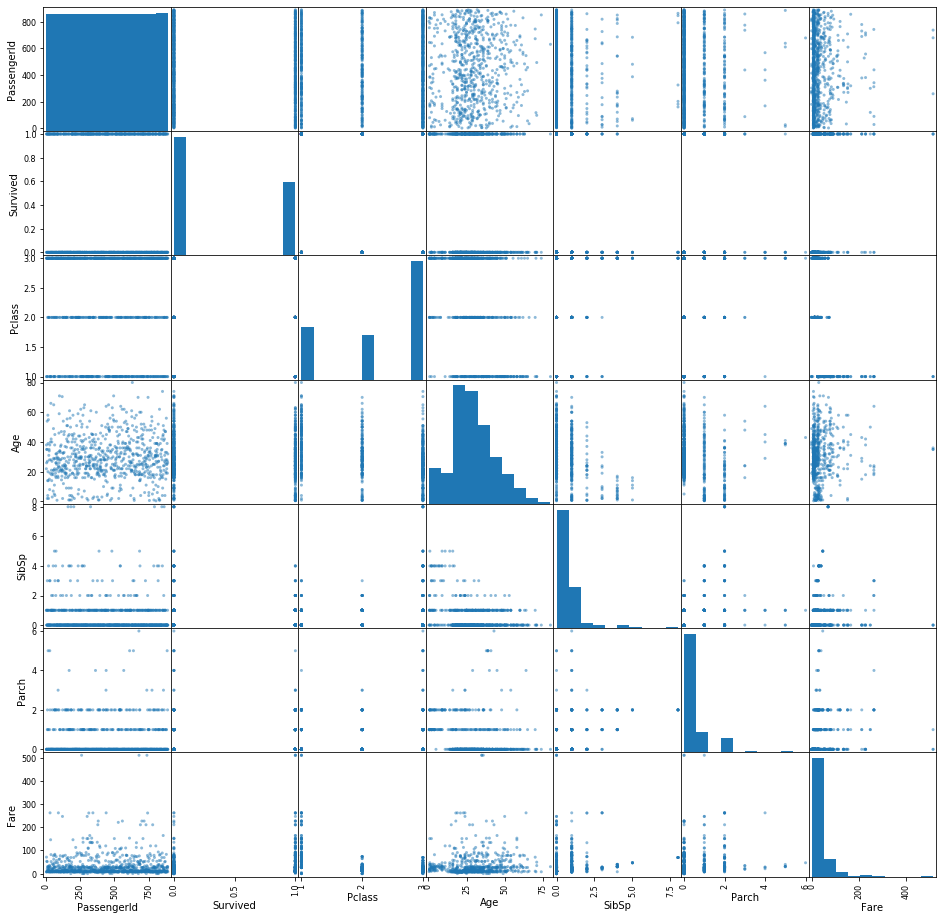

In [9]:
pd.plotting.scatter_matrix(train, alpha=0.5, figsize=(16,16));

In [263]:
#
# Train the model
#
from sklearn.ensemble import RandomForestClassifier

#for n in range(1,200,10):
clf = RandomForestClassifier(n_estimators = 50,
                                 max_features = 3)
clf.fit(X_train, y_train)

clf_meanage = RandomForestClassifier(n_estimators = 50,
                                 max_features = 3)
clf_meanage.fit(X_train_meanage, y_train_meanage)

print(clf.score(X_train,y_train))
print(clf_meanage.score(X_train_meanage, y_train_meanage))

#print(n, clf.score(X_train, y_train))
#n_estimator  = 
#max_features = # sensitive ! = 1 many levels, = many, similar trees

0.9853768278965129
0.9820022497187851


In [280]:
final_results = pd.Series(clf.predict(X_test),index = test['PassengerId'].values)
final_results.to_csv("./titanic_attempt1.csv", header=['Survived'],index_label='PassengerId')

In [281]:
final_results.index

Int64Index([ 892,  893,  894,  895,  896,  897,  898,  899,  900,  901,
            ...
            1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309],
           dtype='int64', length=418)

array([ 892,  893,  894,  895,  896,  897,  898,  899,  900,  901,  902,
        903,  904,  905,  906,  907,  908,  909,  910,  911,  912,  913,
        914,  915,  916,  917,  918,  919,  920,  921,  922,  923,  924,
        925,  926,  927,  928,  929,  930,  931,  932,  933,  934,  935,
        936,  937,  938,  939,  940,  941,  942,  943,  944,  945,  946,
        947,  948,  949,  950,  951,  952,  953,  954,  955,  956,  957,
        958,  959,  960,  961,  962,  963,  964,  965,  966,  967,  968,
        969,  970,  971,  972,  973,  974,  975,  976,  977,  978,  979,
        980,  981,  982,  983,  984,  985,  986,  987,  988,  989,  990,
        991,  992,  993,  994,  995,  996,  997,  998,  999, 1000, 1001,
       1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012,
       1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023,
       1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034,
       1035, 1036, 1037, 1038, 1039, 1040, 1041, 10